In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft

In [2]:
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

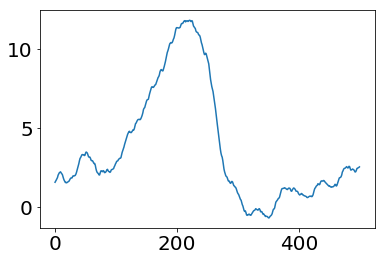

In [3]:
main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior"

response_files = [os.path.join(main_path, file) for file in os.listdir(main_path) if 'responses' in file]
bbb.sort_nicely(response_files)

responses = []
for file in response_files:
    responses.append(np.load(file))
responses = np.asarray(responses)
responses.shape

responses_split = np.reshape(responses, (49-18,2000,4,500))
responses_fft = fft(responses_split,axis=-1)
responses_fft[:,:,:,15:23] = 0
responses_fft[:,:,:,475:485] = 0
responses_filtered = ifft(responses_fft,axis=-1)
responses_filtered = responses_filtered.real
responses_filtered.shape

cluster_id = np.argmax(np.sum(responses_filtered[20,:,0,:].real, axis=1))
plt.plot(responses_filtered[20,cluster_id,0,:])

In [4]:
beh_idx = 3

all_signals = np.reshape(responses_filtered[:,:,:,:],(31*2000,4,500))
all_maxs = np.max(np.abs(all_signals),axis=-1)
thresholds = np.percentile(all_maxs,75,axis=0)
to_delete = np.where(all_maxs[:,beh_idx]<thresholds[beh_idx])
thresholded_filters = np.delete(all_signals[:,beh_idx,:], to_delete, axis=0)
peaks = np.argmax(thresholded_filters,axis=-1)
idx_sort = np.argsort(peaks)

all_maxs = np.max(thresholded_filters,axis=-1)
thresholded_filters_norm = thresholded_filters/all_maxs[:,np.newaxis]

In [5]:
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                memory=main_path,
                                linkage='ward')
model = model.fit(thresholded_filters_norm)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
0.2244882583618164


In [6]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [245]:
###############
n_clusters = 5
###############

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Create the same # of colors as # of clusters
custom_cmap = cm.jet(np.linspace(0, 1, n_clusters))
cluster_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors)

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

### mean cluster responses

cluster_responses = []
for n in np.unique(cluster_ids):
    cluster_response = np.mean(thresholded_filters_norm[cluster_ids==n,:], axis=0)
    cluster_responses.append(cluster_response)
    
cluster_colors_for_brain = cluster_colors[:]
cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

add_deleted_voxels = np.zeros(62000)
to_replace = [i for i in range(62000) if i not in to_delete[0]]
add_deleted_voxels[to_replace] = cluster_ids #model.labels_ ### put signal here
to_plot = np.reshape(add_deleted_voxels, (31,2000))

# now lets look at the brain with these clusters

all_colored_by_betas = []
for z in range(9,49-9):
    colored_by_betas = np.zeros(256*128)
    for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
        cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
        colored_by_betas[cluster_indicies] = to_plot[z-9,cluster_num]
    colored_by_betas = colored_by_betas.reshape(256,128)
    all_colored_by_betas.append(colored_by_betas)
all_colored_by_betas = np.asarray(all_colored_by_betas)
# to_plot = np.max(all_colored_by_betas, axis=0)
# plt.imshow(to_plot[:,:].T)
#all_colored_by_betas[all_colored_by_betas==0] = np.nan

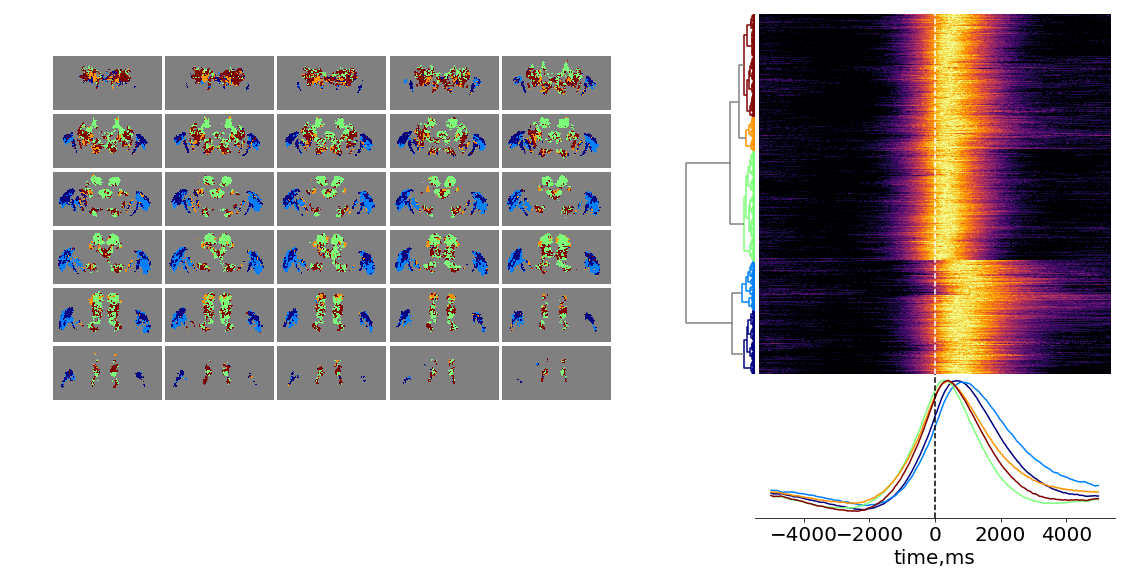

In [246]:
fig = plt.figure(figsize=(10,10))

### dendrogram ###
ax_dendrogram = fig.add_axes([1, .3, .1, .5])
ax_dendrogram.axis('off')
dend = dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey',
           orientation='left');

### all resp ###
ax_dend = fig.add_axes([.85, .3, 1, .5])
ax_dend.imshow(thresholded_filters_norm[dend['leaves'][::-1],:][:,::-1],vmin=0,vmax=1,aspect=0.033,cmap='inferno')
ax_dend.axis('off')
for line in [250]:
    ax_dend.axvline(line,color='w',linestyle='--')    
#plt.title('top 25% fwd, ward, normalized')

### Mean resp ###
ax = fig.add_axes([1.1, 0.1, .5, .2])
timepoints = list(range(-5000,0,20)) + list(range(0,5000,20))
for n in range(len(np.unique(cluster_ids))):
    ax.plot(timepoints, cluster_responses[n][::-1],color=cluster_colors[n])
ax.axvline(0,color='k',linestyle='--')
ax.set_xlabel('time,ms')
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

### BRAIN ###
#ax = fig.add_axes([1.5, 1.5, 1, 1])
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for i in range(30):
    cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap=cmap);
    grid[i].axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

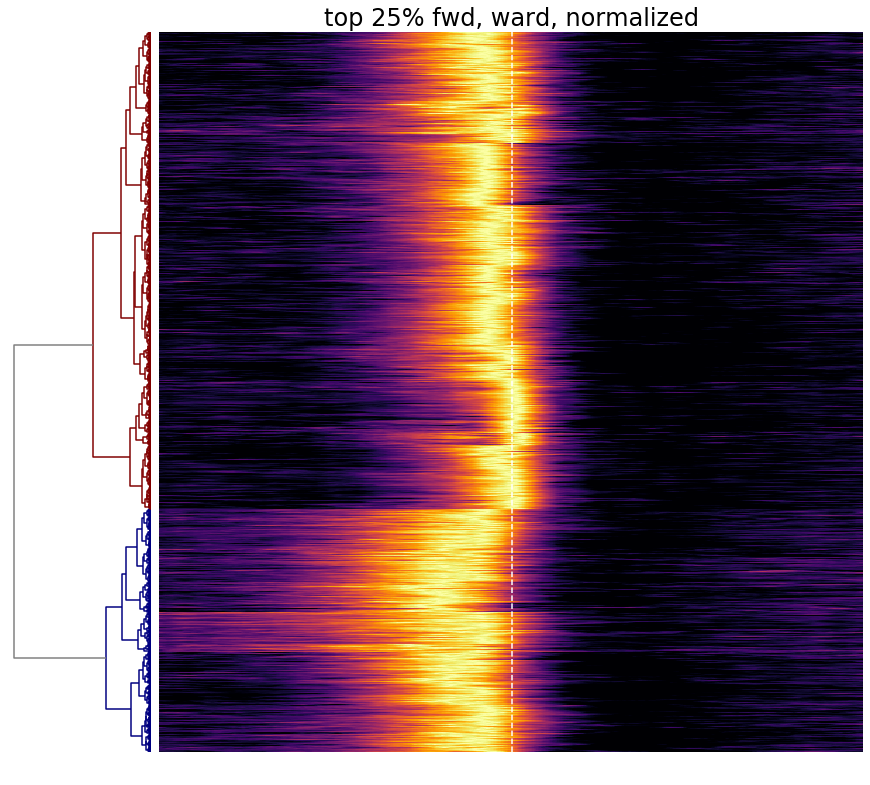

In [194]:
fig = plt.figure(figsize=(10,10))

ax_dendrogram = fig.add_axes([1, 1, .2, 1])
ax_dendrogram.axis('off')
dend = dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           #link_color_func=lambda x: colors[x],
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey',
           orientation='left');

ax = fig.add_axes([1.2, 1, 1, 1])
ax.imshow(thresholded_filters_norm[dend['leaves'][::-1],:],vmin=0,vmax=1,aspect=0.033,cmap='inferno')
ax.axis('off')
for line in [250]:
    ax.axvline(line,color='w',linestyle='--')    
plt.title('top 25% fwd, ward, normalized')

#ax_dend_hist = fig.add_axes([2, 0, .3, 1],sharey=ax_dendrogram)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

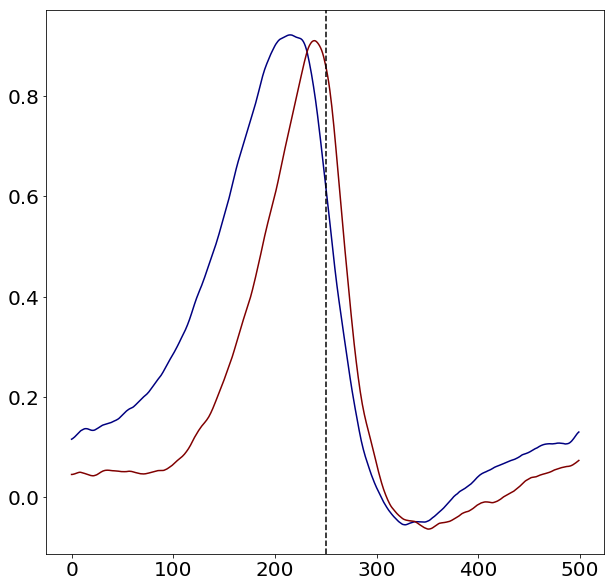

In [196]:
plt.figure(figsize=(10,10))
for n in range(len(np.unique(cluster_ids))):
    plt.plot(cluster_responses[n],color=cluster_colors[n])
plt.axvline(250,color='k',linestyle='--')

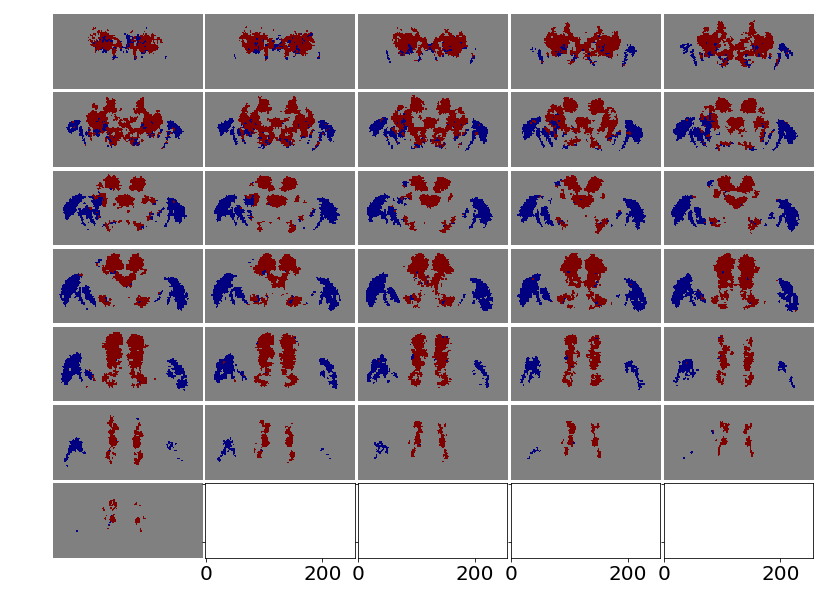

In [200]:
fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 5), axes_pad=.05)
for i in range(31):
    cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap=cmap);
    grid[i].axis('off')

#cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.4, anchor=(1.3,.5))
#cbar.ax.set_yticklabels(['-300ms', '0', '+600ms'], fontsize=12)
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')#